# Imports

In [168]:
from numpy.random import seed
seed(888)
from tensorflow import set_random_seed
set_random_seed(404)

In [238]:
import os
import numpy as np
import tensorflow as tf
import itertools

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [233]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [171]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [172]:
type(cifar10)
type(x_train_all)

numpy.ndarray

# Explore the Data

In [173]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

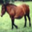

In [174]:
pic = array_to_img(x_train_all[7])
display(pic)

In [175]:
y_train_all.shape

(50000, 1)

In [176]:
y_train_all[7][0]

7

In [177]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

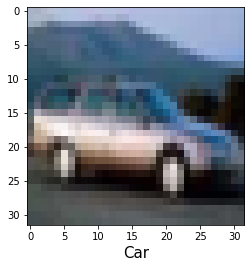

In [178]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

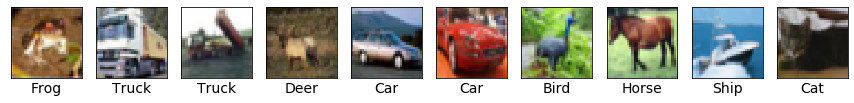

In [179]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
    plt.imshow(x_train_all[i])

In [180]:
x_train_all[0].shape

(32, 32, 3)

In [181]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [182]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [183]:
x_train_all[0][0][0][0]

59

In [184]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [185]:
x_train_all / 255.0

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [186]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [187]:
type(x_train_all[0][0][0][0])

numpy.float64

In [188]:
x_train_all[0][0][0][0]

0.23137254901960785

In [189]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [190]:
x_train_all.shape

(50000, 3072)

In [191]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


### Create Validation Dataset

In [192]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [193]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

### Create a small dataset (for illustration)

In [194]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [195]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(16, activation='relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_hidden4')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [196]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [197]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(16, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [198]:
type(model_1)

keras.engine.sequential.Sequential

In [199]:
model_1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_hidden4 (Dense)           (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [200]:
32*32*3*128 + 128 + (128*64 + 64) + (64*16 + 16) + (16*10 + 10)

402810

# Tensorboard (visualising learning)

In [201]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully create directory')

    return TensorBoard(log_dir=dir_paths)

# Fit the model

In [202]:
samples_per_batch = 1000

In [203]:
# %%time
# nr_epochs = 150
# model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
#             callbacks=[get_tensorboard('Model 1')], verbose=0, validation_data=(x_val, y_val))

In [204]:
%%time
nr_epochs = 100
model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 1 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully create directory
Wall time: 4min 10s


In [205]:
%%time
nr_epochs = 100
model_2.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 2 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully create directory
Wall time: 5min 48s


In [206]:
%%time
nr_epochs = 100
model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 3 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully create directory
Wall time: 6min 33s


# Predictions on Individual Images

In [207]:
x_val.shape

(10000, 3072)

In [208]:
x_val[0].shape

(3072,)

In [210]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

(1, 3072)

In [211]:
np.set_printoptions(precision=3)

In [212]:
model_2.predict(x_val).shape

(10000, 10)

In [213]:
model_2.predict_classes(test)

array([6], dtype=int64)

In [214]:
y_val[0]

array([6], dtype=uint8)

In [216]:
for number in range(10):
    test_img = np.expand_dims(x_val[number], axis=0)
    predicted_val = model_2.predict_classes(test_img)[0]
    print(f'Actual value: {y_val[number][0]} vs. predicted: {predicted_val}')

Actual value: 6 vs. predicted: 6
Actual value: 9 vs. predicted: 1
Actual value: 9 vs. predicted: 9
Actual value: 4 vs. predicted: 6
Actual value: 1 vs. predicted: 9
Actual value: 1 vs. predicted: 9
Actual value: 2 vs. predicted: 6
Actual value: 7 vs. predicted: 7
Actual value: 8 vs. predicted: 8
Actual value: 3 vs. predicted: 9


# Evaluation

In [217]:
model_2.metrics_names

['loss', 'accuracy']

In [219]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss} and test accuracy is {test_accuracy:0.1%}')

10000/10000 [==============================] - 1s 54us/step
Test loss is 1.424784504890442 and test accuracy is 49.1%


### Confusion Matrix

In [222]:
predictions = model_2.predict_classes(x_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [223]:
conf_matrix.shape

(10, 10)

In [224]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [225]:
conf_matrix.max()

617

In [226]:
conf_matrix.min()

8

In [239]:
conf_matrix[0]

array([550,  39,  66,  22,  59,  13,  18,  56, 117,  60], dtype=int64)

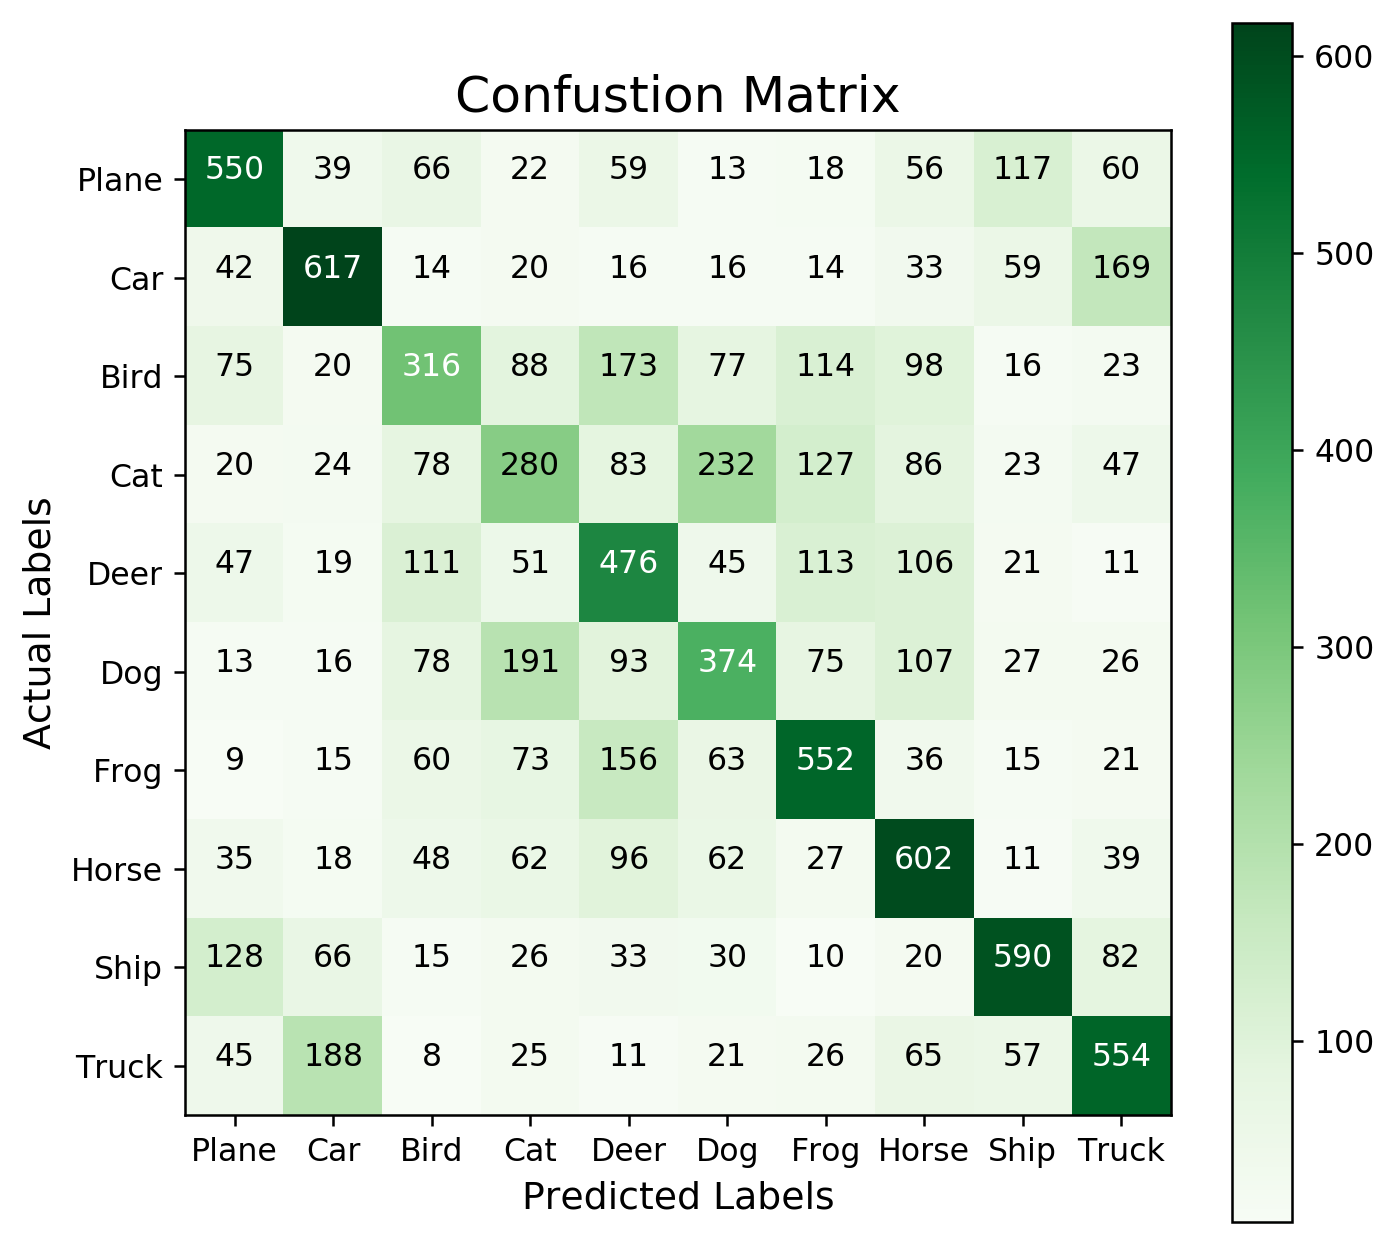

In [245]:
plt.figure(figsize=(7,7), dpi=227)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confustion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.show()

In [246]:
# True Positives
np.diag(conf_matrix)

array([550, 617, 316, 280, 476, 374, 552, 602, 590, 554], dtype=int64)

In [247]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.55 , 0.617, 0.316, 0.28 , 0.476, 0.374, 0.552, 0.602, 0.59 ,
       0.554])

In [248]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.571, 0.604, 0.398, 0.334, 0.398, 0.401, 0.513, 0.498, 0.63 ,
       0.537])

In [249]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 49.11%


In [250]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 2 f score is {f1_score:.2%}')

Model 2 precision score is 0.4883329057289118
Model 2 f score is 48.97%
